## <div style="text-align: center"> Binary Classification of Machine Failures </div>
### <div style="text-align: center"> Playground Series - Season 3, Episode 17 </div>
---

## 📂 Data

<center>

| Filename | Description |
| - | - |
| train.csv |  the training dataset; Machine failure is the (binary) target (which, in order to align with the ordering of the original dataset, **is not in the last column position)** |
| test.csv | the test dataset; your objective is to predict the probability of Machine failure |
| sample_submission.csv | a sample submission file in the correct format |

</center>


# 0 | ⚙ setup

In [1]:
from pathlib import Path

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import (
    train_test_split,
    StratifiedKFold
)
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (
    OneHotEncoder,
    OrdinalEncoder,
    StandardScaler
)
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import (
    HistGradientBoostingClassifier,
    RandomForestClassifier,
    StackingClassifier,
)
from lightgbm import LGBMClassifier
from sklearn.metrics import (
    confusion_matrix,
    classification_report
)
from sklearn.base import BaseEstimator, TransformerMixin


In [2]:
is_kaggle = False

data_dir = Path(
    "/kaggle/input/playground-series-s3e17" if is_kaggle else "../data/"
)
train_data_path = data_dir / "train.csv"
test_data_path = data_dir / "test.csv"
submission_data_path = data_dir / "sample_submission.csv"

split_num = 5
test_size = 0.3
random_state = 1


# 1 | 📂 load train data

In [3]:
data = pd.read_csv(train_data_path)

feature_cols = [
    "Product ID",
    "Type",
    "Air temperature [K]",
    "Process temperature [K]",
    "Rotational speed [rpm]",
    "Torque [Nm]",
    "Tool wear [min]",
    "TWF",
    "HDF",
    "PWF",
    "OSF",
    "RNF"
]

target_col = "Machine failure"
target = data.pop(target_col)

display(data)


,id,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],TWF,HDF,PWF,OSF,RNF
0,0,L50096,L,300.6,309.6,1596,36.1,140,0,0,0,0,0
1,1,M20343,M,302.6,312.1,1759,29.1,200,0,0,0,0,0
2,2,L49454,L,299.3,308.5,1805,26.5,25,0,0,0,0,0
3,3,L53355,L,301.0,310.9,1524,44.3,197,0,0,0,0,0
4,4,M24050,M,298.0,309.0,1641,35.4,34,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
136424,136424,M22284,M,300.1,311.4,1530,37.5,210,0,0,0,0,0
136425,136425,H38017,H,297.5,308.5,1447,49.1,2,0,0,0,0,0
136426,136426,L54690,L,300.5,311.8,1524,38.5,214,0,0,0,0,0
136427,136427,L53876,L,301.7,310.9,1447,46.3,42,0,0,0,0,0


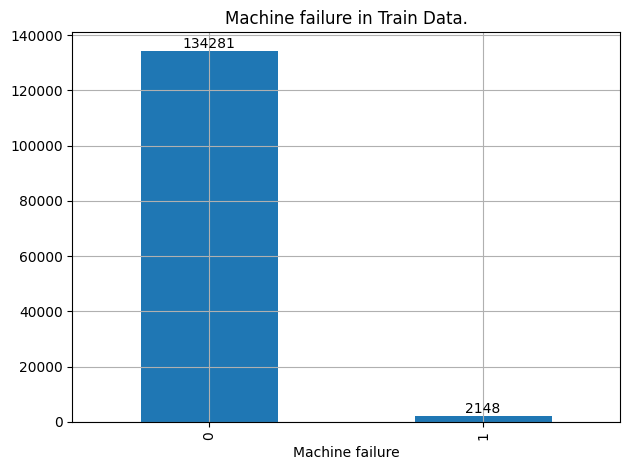

In [4]:
# Check the number of Machine failure in training data.

fig, ax = plt.subplots(1, 1)
target.value_counts().plot(ax=ax, kind="bar")
for bars in ax.containers:
    ax.bar_label(bars)

ax.set_title("Machine failure in Train Data.")
ax.grid()
fig.tight_layout()
plt.close()

display(fig)


# 2 | 📚 Make training dataset...

In [5]:
# Set features categories
numeric_feats = [
    "Air temperature [K]",
    "Process temperature [K]",
    "Rotational speed [rpm]",
    "Torque [Nm]",
    "Tool wear [min]",
]

categorical_feats = [
    "TWF",
    "HDF",
    "PWF",
    "OSF",
    "RNF"
]

# Need One-Hot-Encoding this columns
onehot_feat = [
    "Type"
]

# Need Ordinal Encording this columns
ordinal_feat = [
    "Product ID"
]


In [6]:
# Split training and validation.
train_idx, valid_idx = train_test_split(
    data.index,
    test_size=test_size,
    random_state=random_state,
    shuffle=True,
    stratify=target
)

train_X, train_y = data.loc[train_idx, feature_cols], target[train_idx]
valid_X, valid_y = data.loc[valid_idx, feature_cols], target[valid_idx]


In [7]:
# Calculate class weights from the number of machine failure in the train data.
class_weights = abs(1 - train_y.value_counts() / train_y.shape[0]).to_dict()


# 3 | 🔨 Make Classifier Pipeline.

In [8]:
def make_stacking_classifier_pipeline(
    models,
    base_preprocessor,
    meta_model=LogisticRegression()
):
    model_pipelines = [
        (
            f"{model.__class__.__name__}_{i:02}",
            Pipeline(
                steps=[
                    ("Preprocessor", base_preprocessor),
                    (f"{model.__class__.__name__}_{i:02}", model)
                ]
            )
        )
        for i, model in enumerate(models)
    ]

    # Stacking all models.
    stacking_classifier = StackingClassifier(
        estimators=model_pipelines,
        final_estimator=meta_model
    )

    return stacking_classifier


## 🔧 FeatureEngineering

In [9]:
class ProcessingMachineFeatureEngineer(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X["Temperature Ratio"] = (
            X["Process temperature [K]"] / X["Air temperature [K]"]
        )

        X["Process Power"] = (X["Torque [Nm]"] * X["Rotational speed [rpm]"])

        return X[["Temperature Ratio", "Process Power"]]

    def get_feature_names_out(self, input_features=None):
        return np.array(["Temperature Ratio", "Process Power"], dtype=object)


# 4 | 🤖 Train Classifier.

In [10]:
def plot_confusion_matrix(
    true_y,
    pred_y,
    labels=None,
    ax=None,
    fontsize=13,
    cmap="Blues",
    heatmap_kws=dict()
):
    cm = pd.DataFrame(
        confusion_matrix(true_y, pred_y),
        index=labels,
        columns=labels,

    )

    sns.heatmap(
        cm,
        ax=ax,
        square=True,
        annot=True,
        cbar=True,
        linewidth=2.0,
        fmt="d",
        cmap=cmap,
        ** heatmap_kws
    )

    ax.set_ylim(len(cm), 0)
    ax.set_xlabel("Predict", fontsize=fontsize, rotation=0)
    ax.set_ylabel("Actual", fontsize=fontsize)

    return ax


def plot_classification_report(cr: pd.DataFrame, ax=None, labelsize=13):

    sns.heatmap(
        cr.iloc[:-2, :],
        vmin=0.0,
        vmax=1.0,
        cmap=sns.color_palette("Blues", 24),
        fmt='0.4g',
        linewidth=2.0,
        annot=True,
        annot_kws=dict(size=14),
        ax=ax,
    )
    ax.tick_params(axis='x', labelsize=labelsize)
    ax.tick_params(axis='y', labelsize=labelsize)
    return ax


def edit_classification_report(cr: pd.DataFrame):
    supports = ('\n(' + cr.iloc[:-3, -1].astype(int).astype(str) + ')')
    cr.index = (cr.index[:-3] + supports).to_list() + cr.index[-3:].to_list()
    cr = cr.iloc[:, :-1].copy()
    cr.iloc[-3:, :-1] = np.nan
    return cr


In [11]:
validator = StratifiedKFold(
    split_num,
    shuffle=True,
    random_state=random_state
)

stacking_models = []
result = pd.DataFrame(
    data=-1,
    index=train_X.index,
    columns=['predict', 'proba', 'fold']
)


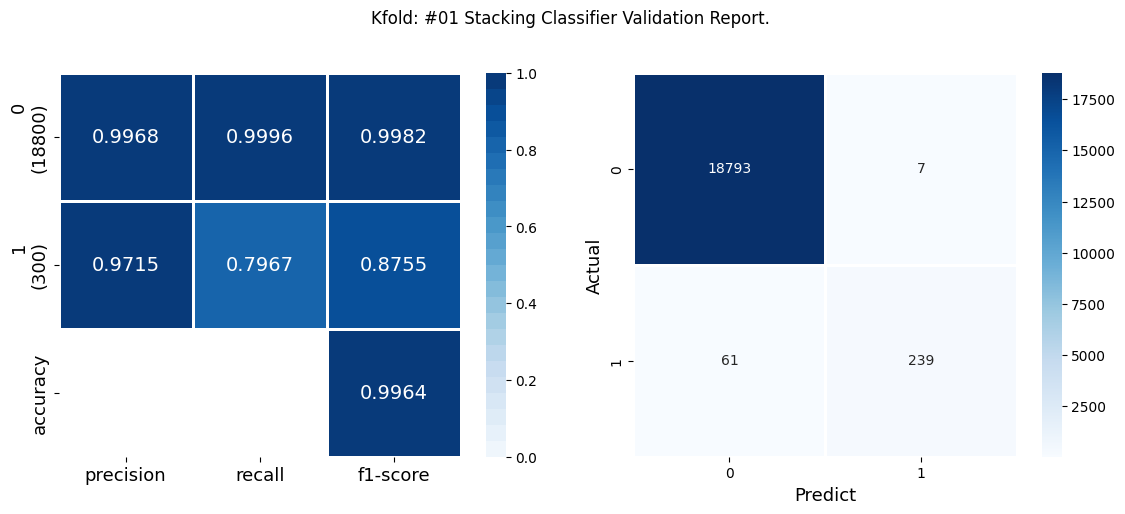

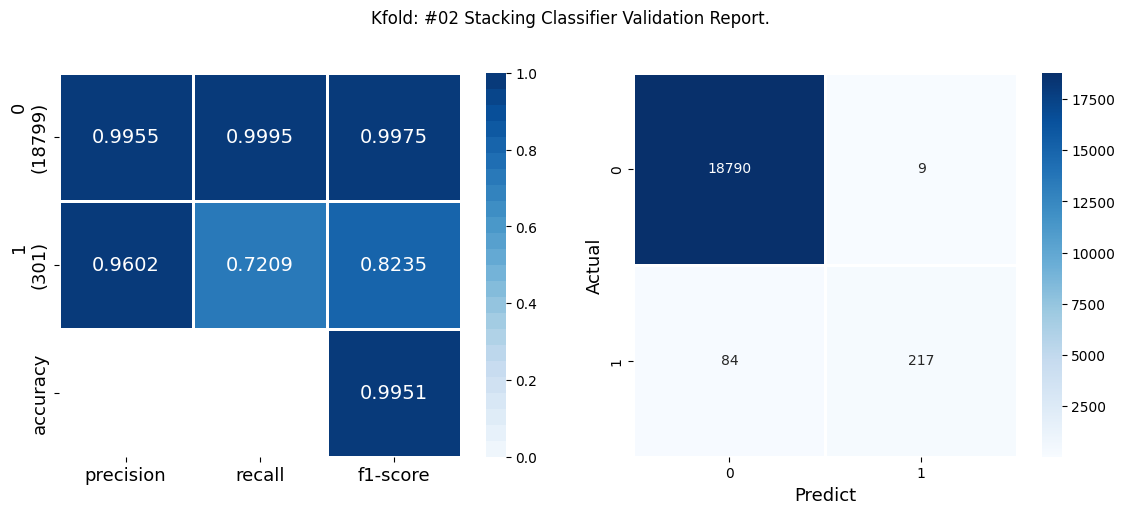

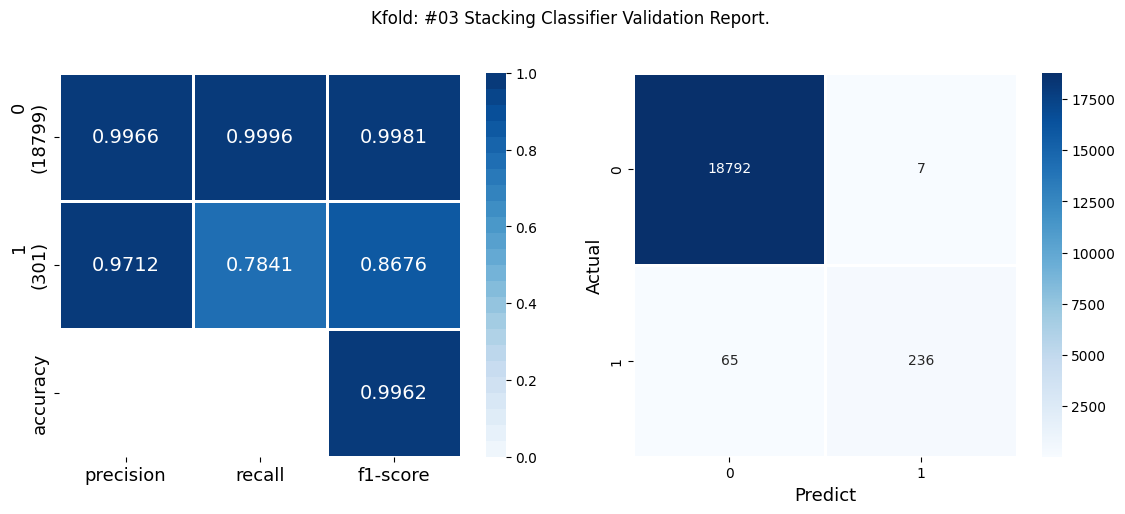

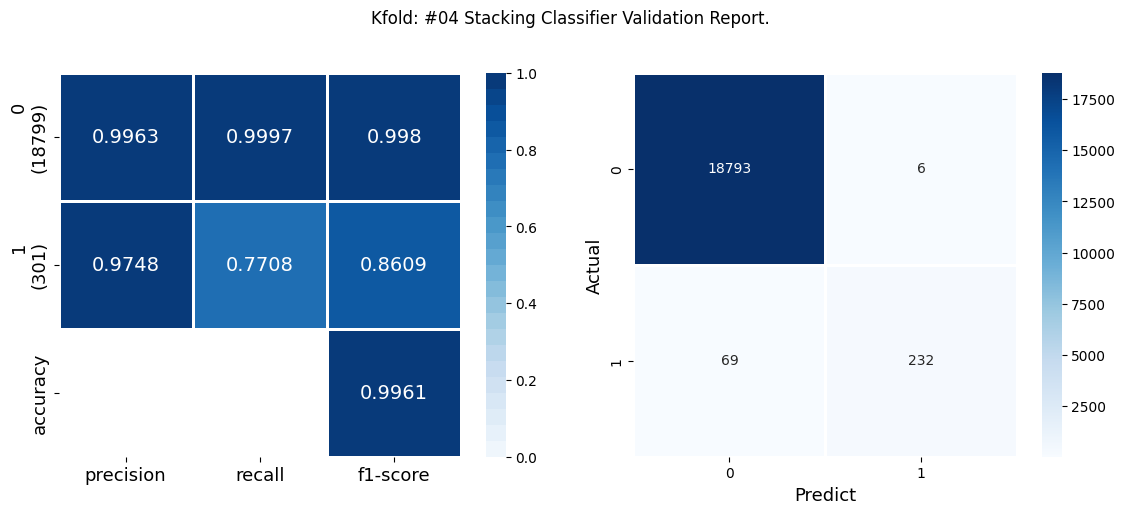

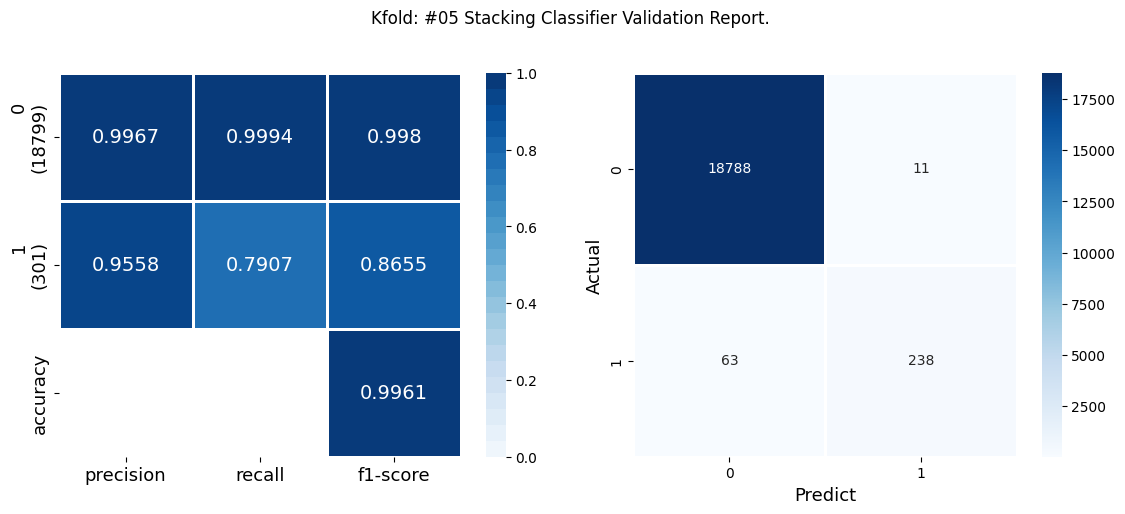

In [12]:
for i, (tidx, vidx) in enumerate(validator.split(train_X.index, train_y)):
    featurengineering_transformer = Pipeline(
        steps=[
            ('FeatureEngineerin|g', ProcessingMachineFeatureEngineer()),
            ('StandardScaler', StandardScaler())
        ]
    )

    stackingclassifier = make_stacking_classifier_pipeline(
        models=[
            GaussianNB(),
            HistGradientBoostingClassifier(
                class_weight=class_weights,
                random_state=random_state + i
            ),
            LGBMClassifier(
                class_weight=class_weights,
                random_state=random_state + i
            ),
            RandomForestClassifier(
                class_weight=class_weights,
                random_state=random_state + i
            ),
        ],
        base_preprocessor=ColumnTransformer(
            transformers=[
                ('FeatureEngineering', featurengineering_transformer, numeric_feats),
                ('Scaler',  StandardScaler(), numeric_feats),
                ('One-Hot', OneHotEncoder(handle_unknown='ignore'), onehot_feat),
                ('Ordinal', OrdinalEncoder(
                    handle_unknown='use_encoded_value', unknown_value=-1,), ordinal_feat)
            ],
            remainder="passthrough"
        ),
        meta_model=LogisticRegression()
    )

    stackingclassifier.fit(train_X.iloc[tidx, :], train_y.iloc[tidx])
    # Predict Valid Data.
    pred_y = stackingclassifier.predict(train_X.iloc[vidx, :])
    result.iloc[vidx, 0] = pred_y
    result.iloc[vidx, 1] = stackingclassifier.predict_proba(
        train_X.iloc[vidx, :]
    )[:, 1]
    result.iloc[vidx, 2] = (i + 1)

    stacking_models.append(stackingclassifier)
    report = edit_classification_report(
        pd.DataFrame(
            classification_report(
                train_y.iloc[vidx],
                pred_y,
                output_dict=True,
            )
        ).transpose()
    )

    fig, axes = plt.subplots(1, 2, figsize=(11.5, 5))
    fig.suptitle(f"Kfold: #{i+1:02} Stacking Classifier Validation Report.")
    plot_classification_report(report, ax=axes[0])
    plot_confusion_matrix(train_y.iloc[vidx], pred_y, ax=axes[1])
    fig.tight_layout(rect=[0, 0, 1, 0.96])
    plt.close()

    display(fig)


# 5 | 🧑‍⚖️ Evaluate Classifier

In [14]:
def predict_from_models(models, X, threshold=0.50):
    probas_y = np.array([model.predict_proba(X) for model in models])
    proba_y = probas_y[:, :, 1].mean(axis=0)
    pred_y = np.where(proba_y >= threshold, 1, 0)
    return pred_y


In [15]:
pred_y = predict_from_models(stacking_models, valid_X)

report = edit_classification_report(
    pd.DataFrame(
        classification_report(
            valid_y,
            pred_y,
            output_dict=True,
        )
    ).transpose()
)


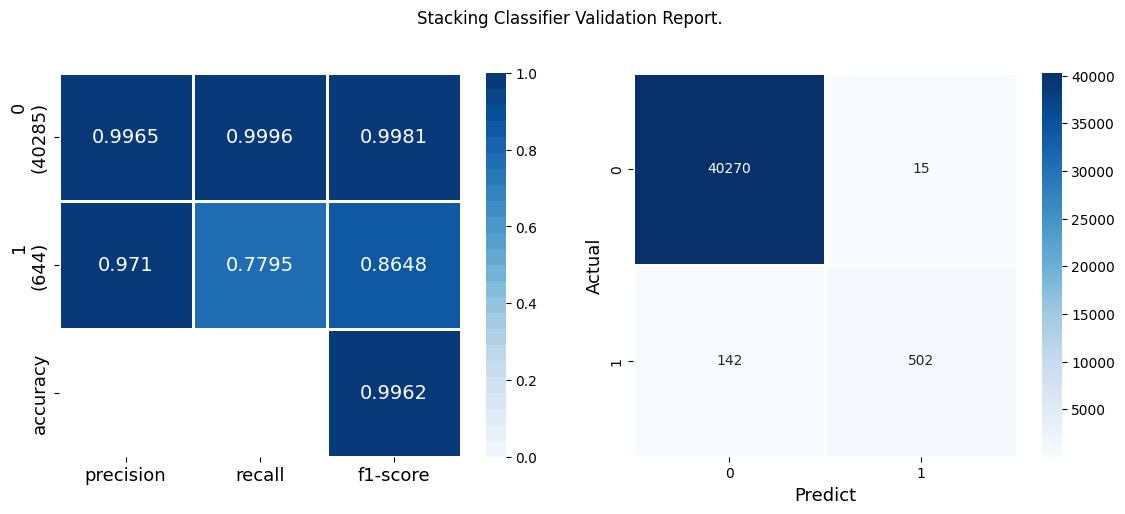

In [16]:
fig, axes = plt.subplots(1, 2, figsize=(11.5, 5))
fig.suptitle("Stacking Classifier Validation Report.")
plot_classification_report(report, ax=axes[0])
plot_confusion_matrix(valid_y, pred_y, ax=axes[1])
fig.tight_layout(rect=[0, 0, 1, 0.96])
plt.close()

display(fig)


# 6 | 📤 Submission

In [17]:
def predict_proba_from_models(models, X):
    probas_y = np.array([model.predict_proba(X) for model in models])
    proba_y = probas_y[:, :, 1].mean(axis=0)
    return proba_y


In [18]:
# make submission file
test_data = pd.read_csv(test_data_path)
test_proba = predict_proba_from_models(stacking_models, test_data)

sub = pd.read_csv(submission_data_path)
sub["Machine failure"] = test_proba[:]
sub.to_csv(f"submission_{'_'.join([name[:-3] for name, est in stacking_models[0].estimators])}_nousing_classweight_withProductID_FeatureEngineering.csv", index=False)


---